In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

from DataProc.DataProcessor import DataProcessor
from Datasets.BaseballDataset import BaseballDataset
from BaselineModel.BaselineModel import BaselineModel
from TransformerModel.TransformerModelRedisual import *

import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
data_config_path = "../../data/configv3.json"
full_data_path = "../../data/full_cleaned_94.csv"
sequence_length = 200
full_data = pd.read_csv(full_data_path)


In [3]:
scaler_path = "../../data/full_scalers_94.pkl"

In [4]:
#only use 2024 data for now
data_2024 = full_data[full_data['game_date'] > '2024-01-01']

#player names in 2024
names = data_2024['batter_name'].unique()

In [5]:
m_path = "../fixed_94_200/h6_e12_h96_d0_lp0.5_lr1e-05_ep50/transformer_model.pth"
c_path = "../fixed_94_200/h6_e12_h96_d0_lp0.5_lr1e-05_ep50/model_config.json"

transformer_model = TransformerHelper(m_path,c_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import warnings



# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    verbose = False
    cont_errors = []

    events_errors = []
    events_precisions = []

    loc_errors = []
    loc_precisions = []

    player_names = []
    data_sizes = []

    all_event_preds = []
    all_loc_preds = []

    all_event_true = []
    all_loc_true = []



    for name in names:
        # Create dataset for this player
        player_data = data_2024[data_2024['batter_name'] == name].reset_index(drop=True)

        print(name,len(player_data))

        if len(player_data) < sequence_length:
            continue

        player_dataset = BaseballDataset(player_data, data_config_path, sequence_length)

        if len(player_dataset) < 1:
            continue

        player_names.append(name)
        data_sizes.append(len(player_dataset))

        #print(name,len(player_dataset))

        # Get preds and true using this dataset
        player_preds, player_true = transformer_model.make_preds(player_dataset, scaler_path, device, 2000, scale=True)

        #print(player_preds.columns)

        # First 4 columns are continuous preds/labels
        cont_preds = player_preds.iloc[:, 0:4]
        cont_true = player_true.iloc[:, 0:4]

        # Next 10 columns are probabilities for the events categorical feature
        events_preds = player_preds.iloc[:, 4:14]
        events_true = player_true.iloc[:, 4:14]



        # Last 10 columns are probabilities for the hit_location categorical feature
        loc_preds = player_preds.iloc[:, 14:]
        loc_true = player_true.iloc[:, 14:]


        cont_error = np.abs(cont_true - cont_preds)
        cont_errors.append(cont_error)




        # Summing the probability distributions for events and hit_location
        pred_events_sum = events_preds.sum(axis=0)
        true_events_sum = events_true.sum(axis=0)


        all_event_preds.append(pred_events_sum)
        all_event_true.append(true_events_sum)

        pred_loc_sum = loc_preds.sum(axis=0)
        true_loc_sum = loc_true.sum(axis=0)

        all_loc_preds.append(pred_loc_sum)
        all_loc_true.append(true_loc_sum)


        events_sum_abs_errors = np.abs(pred_events_sum - true_events_sum).values
        loc_sum_abs_errors = np.abs(pred_loc_sum - true_loc_sum).values

        if verbose:
            print(f"Sum of absolute errors for Events for {name}: {events_sum_abs_errors}")
            print(f"Sum of absolute errors for Hit Location for {name}: {loc_sum_abs_errors}")

        events_errors.append(events_sum_abs_errors)
        loc_errors.append(loc_sum_abs_errors)


        top_k = 4

        # Get top-k predictions for each sample, returning the numeric index instead of column names
        events_top_k_preds = events_preds.apply(lambda x: x.nlargest(top_k).index.map(lambda name: events_preds.columns.get_loc(name)), axis=1)
        loc_top_k_preds = loc_preds.apply(lambda x: x.nlargest(top_k).index.map(lambda name: loc_preds.columns.get_loc(name)), axis=1)

        # Now the predictions are stored as the numeric indices corresponding to the classes

        # Compute precision for each class
        events_class_precisions = []
        loc_class_precisions = []

        # For each class in events and hit_location, calculate top-k precision
        for class_idx in range(10):
            # For events precision
            true_class_mask = events_true.iloc[:, class_idx] == 1  # Find where this class is the true class
            true_class_indices = events_true.index[true_class_mask]
            
            # Check if this class is in the top-k predictions when it's the true class
            event_precision = np.mean([1 if class_idx in events_top_k_preds.iloc[i] else 0 for i in true_class_indices])
            events_class_precisions.append(event_precision)

            # For hit location precision
            true_class_mask = loc_true.iloc[:, class_idx] == 1  # Find where this class is the true class
            true_class_indices = loc_true.index[true_class_mask]

            # Check if this class is in the top-k predictions when it's the true class
            loc_precision = np.mean([1 if class_idx in loc_top_k_preds.iloc[i] else 0 for i in true_class_indices])
            loc_class_precisions.append(loc_precision)

        if verbose:
            print(f"Class-wise Events Precision for {name}: {events_class_precisions}")
            print(f"Class-wise Hit Location Precision for {name}: {loc_class_precisions}")

        events_precisions.append(events_class_precisions)
        loc_precisions.append(loc_class_precisions)





    





zack gelof 1004
tyler nevin 709
kyle mccann 395
ketel marte 1365
corbin carroll 1376
geraldo perdomo 357
josé herrera 47
eugenio suárez 1368
tyler soderstrom 520
brent rooker 1213
miguel andújar 518
jake mccarthy 844
lourdes gurriel 1298
christian walker 1575
blaze alexander 701
randal grichuk 501
jj bleday 1349
aledmys díaz 101
daz cameron 287
joc pederson 1039
lawrence butler 677
tucker barnhart 403
zack short 391
orlando arcia 1209
sean murphy 357
adam duvall 797
austin riley 1141
connor joe 1157
jack suwinski 955
jared triolo 1047
matt olson 1521
marcell ozuna 1438
ozzie albies 1265
jarred kelenic 955
joey bart 313
nick gonzales 678
rowdy tellez 947
travis d'arnaud 693
edward olivares 784
oneil cruz 1293
bryan reynolds 1513
luke williams 38
andrew mccutchen 1321
colton cowser 1113
heston kjerstad 176
jorge mateo 709
ryan o'hearn 942
austin hays 451
robbie grossman 680
josh smith 1145
marcus semien 1353
davis wendzel 170
jordan westburg 1232
anthony santander 1330
adley rutschman 14

In [7]:
cont_errors[0]

,launch_speed,hc_x,hc_y,launch_angle
0,9.496685,34.904174,17.970411,5.436383
1,0.599193,1.199682,1.184364,3.186561
2,4.920069,23.487659,44.031142,21.128996
3,0.354014,1.896604,1.914552,1.578387
4,0.411008,0.645244,0.793938,0.330905
...,...,...,...,...
799,2.525675,2.695377,1.654367,3.708621
800,5.898867,4.693295,2.919284,23.577575
801,1.680748,0.887482,2.411387,1.210838
802,18.664794,0.109997,7.294248,30.675910


In [8]:
event_class_names = player_dataset.categorical_label_names[0]
loc_class_names = player_dataset.categorical_label_names[1]



# Summary Statistics for Class-wise Errors and Precisions
average_events_class_errors = np.nanmean(events_errors, axis=0)
average_loc_class_errors = np.nanmean(loc_errors, axis=0)

average_events_class_precisions = np.nanmean(events_precisions, axis=0)
average_loc_class_precisions = np.nanmean(loc_precisions, axis=0)

# Create DataFrames for the results
events_summary_df = pd.DataFrame({
    'Class': event_class_names,
    'Average Error': average_events_class_errors,
    f'Average Precision (Top K {top_k})': average_events_class_precisions
})

loc_summary_df = pd.DataFrame({
    'Class': loc_class_names,
    'Average Error': average_loc_class_errors,
    f'Average Precision (Top {top_k})': average_loc_class_precisions
})

# Print formatted DataFrames
print("Events Class-wise Summary:")
print(events_summary_df)

print("\nHit Location Class-wise Summary:")
print(loc_summary_df)

Events Class-wise Summary:
                 Class  Average Error  Average Precision (Top K 4)
0             events_B      14.416407                     0.980858
1             events_S      17.748030                     0.999953
2        events_double       2.493092                     0.271636
3     events_field_out      13.327345                     0.999231
4  events_hit_by_pitch       1.512925                     0.953288
5      events_home_run       2.585735                     0.274642
6        events_single       4.824101                     0.872185
7     events_strikeout      10.251649                     0.995442
8        events_triple       0.701382                     0.000000
9          events_walk       2.307287                     0.938145

Hit Location Class-wise Summary:
              Class  Average Error  Average Precision (Top 4)
0  hit_location_0.0      16.740786                   0.999753
1  hit_location_1.0       1.581497                   0.017981
2  hit_location_

In [9]:
total_error = events_summary_df['Average Error'].sum()

print(f'Average num pitches in datasets: {sum(data_sizes) / len(data_sizes)}')
print(f'Total average error: {total_error}')

Average num pitches in datasets: 635.0314606741573
Total average error: 70.16796112060547


In [10]:
pname = "bryce harper"
idx = player_names.index(pname)


# Create a DataFrame for events errors and precisions
events_df = pd.DataFrame({
    "Error": events_errors[idx],
    "Precision": events_precisions[idx]
}, index=event_class_names)


# Output the DataFrames
print(f"Events DataFrame for {pname}:")
print(f"Num pitches: {data_sizes[idx]}")
print(events_df)

print("\nModel Preds")
print(all_event_preds[idx])
print("\nTrue")
print(all_event_true[idx])


Events DataFrame for bryce harper:
Num pitches: 1109
                         Error  Precision
events_B             10.392944   0.977444
events_S             47.972595   0.997653
events_double         0.652138   0.333333
events_field_out     20.901871   1.000000
events_hit_by_pitch   2.245663        NaN
events_home_run       6.588237   0.058824
events_single        12.707935   0.883721
events_strikeout      9.732788   1.000000
events_triple         1.203653        NaN
events_walk           9.911566   0.885714

Model Preds
events_B               388.607056
events_S               473.972595
events_double           17.347862
events_field_out        89.098129
events_hit_by_pitch      2.245663
events_home_run         10.411763
events_single           30.292065
events_strikeout        70.732788
events_triple            1.203653
events_walk             25.088434
dtype: float32

True
events_B               399.0
events_S               426.0
events_double           18.0
events_field_out       1

In [43]:
#baseline for this comparison will simply be using a players career averages

#pre-2024 data for averages since we are predicting 2024 stats
baseline_data = full_data[full_data['game_date'] < '2024-01-01']

baseline_events_errors = []
baseline_loc_errors = []


for i, player in enumerate(player_names):


    #get pre-2024 data for this player

    player_data = baseline_data[baseline_data['batter_name'] == player]

    
    if len(player_data) == 0:
        continue
    
    event_cols = ['events_B', 'events_S', 'events_double',
       'events_field_out', 'events_hit_by_pitch', 'events_home_run',
       'events_single', 'events_strikeout', 'events_triple', 'events_walk']
    
    player_event_means = player_data[event_cols].sum(axis=0) / len(player_data)

    #multiply by number of pitches seen for 2024 (won't be entire 2024 since the dataset skips first sequence_length (200) pitches)

    baseline_event_preds = player_event_means * data_sizes[i]
    baseline_event_true = all_event_true[i] #true will be the same as before


    baseline_events_sum_abs_errors = np.abs(baseline_event_preds - baseline_event_true).values


    #same for hit_location

    loc_cols = ['hit_location_0.0', 'hit_location_1.0',
       'hit_location_2.0', 'hit_location_3.0', 'hit_location_4.0',
       'hit_location_5.0', 'hit_location_6.0', 'hit_location_7.0',
       'hit_location_8.0', 'hit_location_9.0']
    
    player_loc_means = player_data[loc_cols].sum(axis=0) / len(player_data)

    #multiply by number of pitches seen for 2024 (won't be entire 2024 since the dataset skips first sequence_length (200) pitches)

    baseline_loc_preds = player_loc_means * data_sizes[i]
    baseline_loc_true = all_loc_true[i] #true will be the same as before


    baseline_loc_sum_abs_errors = np.abs(baseline_loc_preds - baseline_loc_true).values



    baseline_events_errors.append(baseline_events_sum_abs_errors)
    baseline_loc_errors.append(baseline_loc_sum_abs_errors)


    


    

    


    

    
    

   
    


In [44]:
# Summary Statistics for Class-wise Errors and Precisions
average_baseline_events_class_errors = np.nanmean(baseline_events_errors, axis=0)
average_baseline_loc_class_errors = np.nanmean(baseline_loc_errors, axis=0)



# Create DataFrames for the results
baseline_events_summary_df = pd.DataFrame({
    'Class': event_class_names,
    'Average Error': average_baseline_events_class_errors
})

baseline_loc_summary_df = pd.DataFrame({
    'Class': loc_class_names,
    'Average Error': average_baseline_loc_class_errors
})

# Print formatted DataFrames
print("Events Class-wise Summary:")
print(baseline_events_summary_df)

print("\nHit Location Class-wise Summary:")
print(baseline_loc_summary_df)

Events Class-wise Summary:
                 Class  Average Error
0             events_B      11.714071
1             events_S      10.505531
2        events_double       3.482255
3     events_field_out       9.290118
4  events_hit_by_pitch       1.180147
5      events_home_run       2.201193
6        events_single       5.031314
7     events_strikeout       5.727173
8        events_triple       0.721195
9          events_walk       3.602065

Hit Location Class-wise Summary:
              Class  Average Error
0  hit_location_0.0      35.023136
1  hit_location_1.0       1.965006
2  hit_location_2.0      36.929131
3  hit_location_3.0       2.656310
4  hit_location_4.0       3.432164
5  hit_location_5.0       3.159369
6  hit_location_6.0       3.540591
7  hit_location_7.0       4.282607
8  hit_location_8.0       4.989288
9  hit_location_9.0       4.420090


In [25]:
#month to month comparison

#includes about ~200 pitches back from end of march so that we are making preds for every pitch in june
judge_2019_july_aug = full_data[(full_data['batter_name'] == 'josh naylor') & (full_data['game_date'] > '2023-01-1') & (full_data['game_date'] < '2023-10-01')].reset_index(drop=True)
judge_2019 = BaseballDataset(judge_2019_july_aug,data_config_path,sequence_length)

#includes about ~200 pitches back from end of may so that we are making preds for every pitch in june
judge_2022_july_aug = full_data[(full_data['batter_name'] == 'aaron judge') & (full_data['game_date'] > '2021-01-1') & (full_data['game_date'] < '2021-10-01')].reset_index(drop=True)
judge_2022 = BaseballDataset(judge_2022_july_aug,data_config_path,sequence_length)





judge_2019_preds, judge_2019_true = transformer_model.make_preds(judge_2019, scaler_path, device, 2000, scale=True)
judge_2022_preds, judge_2022_true = transformer_model.make_preds(judge_2022, scaler_path, device, 2000, scale=True)









In [30]:
judge_2019_preds[judge_2019_true['events_home_run'] == True]['launch_speed'].mean()

82.94621239837377

In [33]:
judge_2022_preds[judge_2022_true['events_home_run'] == True]['launch_speed'].mean()

84.73083187143143

In [26]:
print(f"total pitches: {judge_2019_preds.sum(axis=0)[4:14].sum(axis=0)}\n")


print("Conts")
print(judge_2019_preds.mean(axis=0)[0:4])
print()

print("Judge 2019 Preds")
print(judge_2019_preds.sum(axis=0)[4:])

print()
print("Judge April True")
print(judge_2019_true.sum(axis=0)[4:])



total pitches: 1447.9997401237488

Conts
launch_speed     82.536198
hc_x            127.222866
hc_y            123.660750
launch_angle     17.017557
dtype: float64

Judge 2019 Preds
events_B                413.494568
events_S                665.784241
events_double            22.403372
events_field_out        173.867279
events_hit_by_pitch       6.216268
events_home_run          12.898870
events_single            53.948383
events_strikeout         83.456200
events_triple             1.966283
events_walk              13.964276
hit_location_0.0       1201.625244
hit_location_1.0         10.186934
hit_location_2.0          3.690185
hit_location_3.0         26.237486
hit_location_4.0         34.565945
hit_location_5.0         19.625650
hit_location_6.0         27.705667
hit_location_7.0         47.652508
hit_location_8.0         39.946957
hit_location_9.0         36.763367
dtype: float64

Judge April True
events_B                454.0
events_S                563.0
events_double            

In [34]:
print(f"total pitches: {judge_2022_preds.sum(axis=0)[4:14].sum(axis=0)}\n")

print("Conts")
print(judge_2022_preds.mean(axis=0)[0:4])
print()

print("Judge 2022 Preds")
print(judge_2022_preds.sum(axis=0)[4:])

print()
print("Judge 2022 True")
print(judge_2022_true.sum(axis=0)[4:])


total pitches: 2511.9994356632233

Conts
launch_speed     84.033795
hc_x            125.804580
hc_y            120.569272
launch_angle     17.450986
dtype: float64

Judge 2022 Preds
events_B                884.835388
events_S               1027.905273
events_double            37.275749
events_field_out        185.193665
events_hit_by_pitch      14.413861
events_home_run          44.814476
events_single            71.342949
events_strikeout        178.537231
events_triple             2.523586
events_walk              65.157257
hit_location_0.0       2226.948486
hit_location_1.0          8.034934
hit_location_2.0          5.056206
hit_location_3.0         14.300036
hit_location_4.0         23.624641
hit_location_5.0         32.832184
hit_location_6.0         38.387283
hit_location_7.0         55.035213
hit_location_8.0         52.108765
hit_location_9.0         55.672260
dtype: float64

Judge 2022 True
events_B                940.0
events_S                980.0
events_double            2

In [42]:
judge_2019_true

,launch_speed,hc_x,hc_y,launch_angle,events_B,events_S,events_double,events_field_out,events_hit_by_pitch,events_home_run,...,hit_location_0.0,hit_location_1.0,hit_location_2.0,hit_location_3.0,hit_location_4.0,hit_location_5.0,hit_location_6.0,hit_location_7.0,hit_location_8.0,hit_location_9.0
0,102.400001,72.659998,61.730000,20.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,71.600000,126.660554,123.034914,48.999999,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.300000,82.780000,88.570001,19.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,83.212881,126.660554,123.034914,16.275918,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,83.212881,126.660554,123.034914,16.275918,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,80.600000,195.120003,116.790000,39.999999,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2167,51.000000,126.660554,123.034914,-35.999999,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2168,83.212881,126.660554,123.034914,16.275918,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2169,83.212881,126.660554,123.034914,16.275918,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


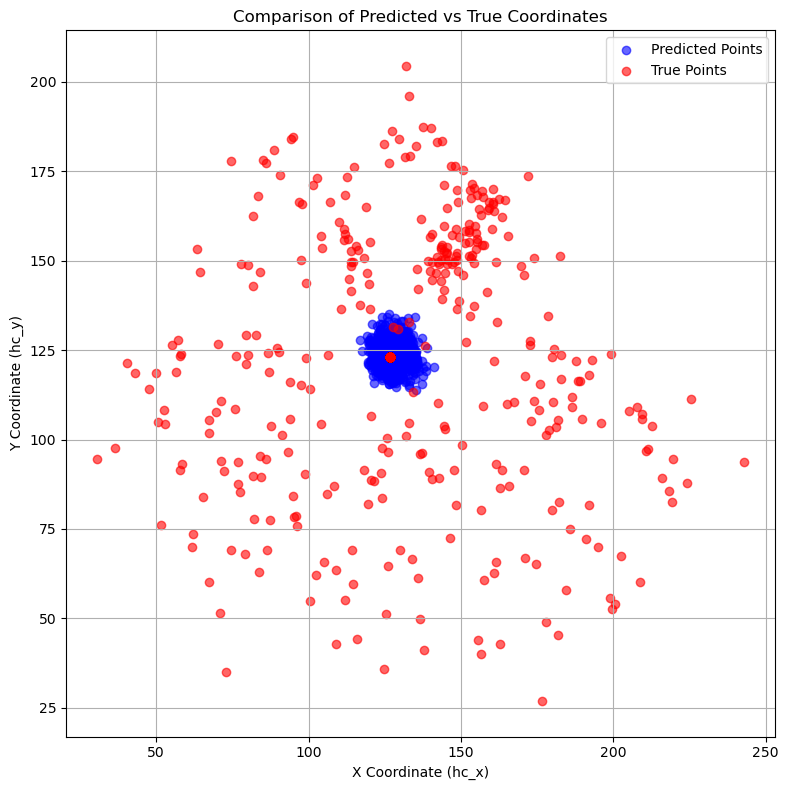

In [39]:
import matplotlib.pyplot as plt

df_pred = judge_2019_preds
df_true = judge_2019_true

# Generate the plot
plt.figure(figsize=(8, 8))

# Plot predicted points
plt.scatter(df_pred['hc_x'], df_pred['hc_y'], color='blue', label='Predicted Points', alpha=0.6)

# Plot true points
plt.scatter(df_true['hc_x'], df_true['hc_y'], color='red', label='True Points', alpha=0.6)

# Add labels and title
plt.xlabel('X Coordinate (hc_x)')
plt.ylabel('Y Coordinate (hc_y)')
plt.title('Comparison of Predicted vs True Coordinates')

# Add grid and legend
plt.grid(True)
plt.legend()

# Optionally, adjust axis limits based on the data
x_min = min(df_pred['hc_x'].min(), df_true['hc_x'].min())
x_max = max(df_pred['hc_x'].max(), df_true['hc_x'].max())
y_min = min(df_pred['hc_y'].min(), df_true['hc_y'].min())
y_max = max(df_pred['hc_y'].max(), df_true['hc_y'].max())

plt.xlim(x_min - 10, x_max + 10)  # Add small buffer
plt.ylim(y_min - 10, y_max + 10)

# Display the plot
plt.tight_layout()
plt.show()



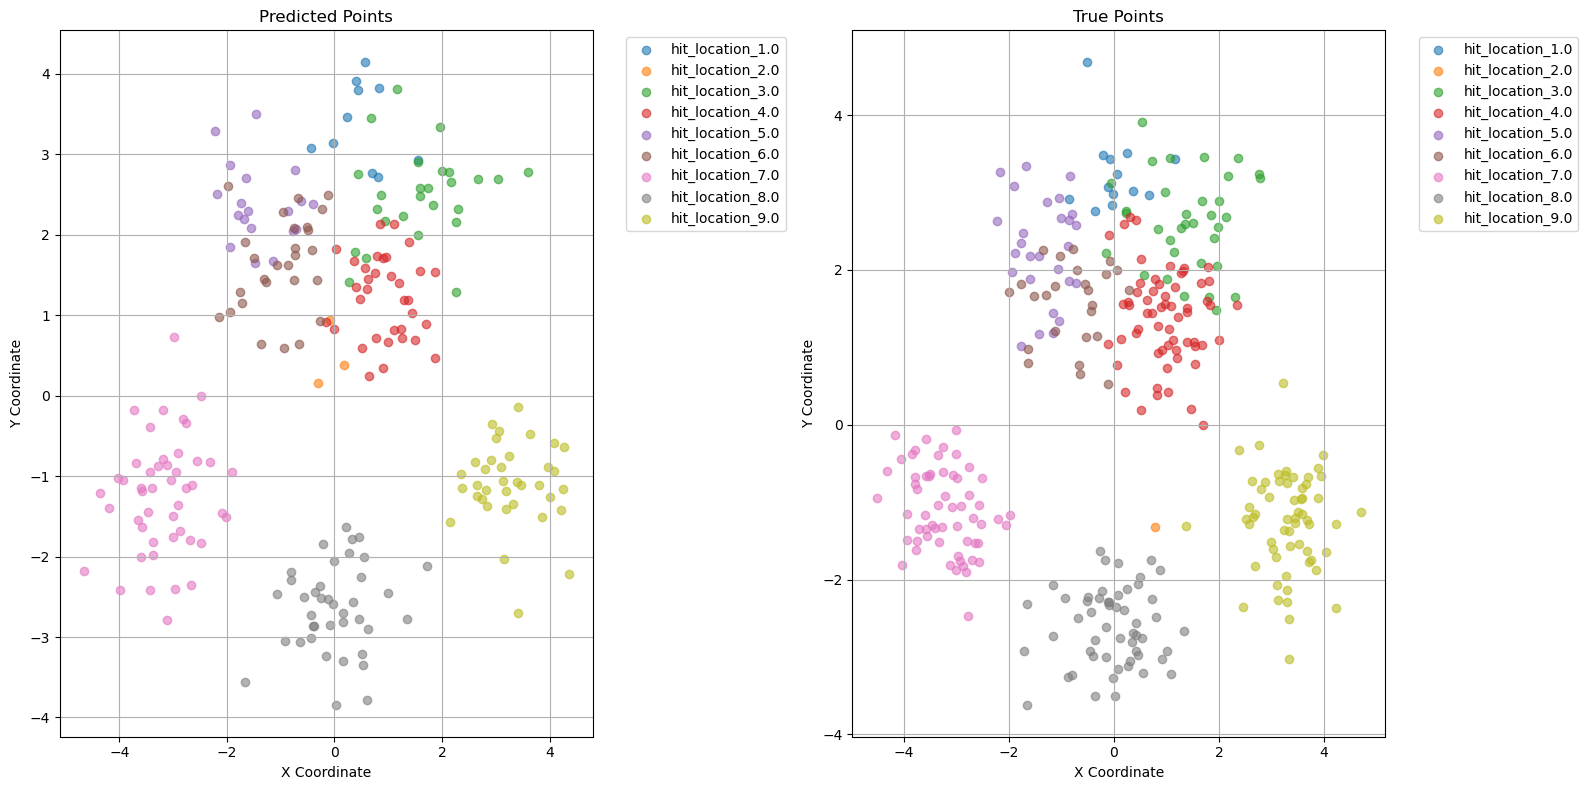

In [40]:


# Means for each hit_location
hit_location_means = {
    'hit_location_0.0': (-0.003983073196223652, -0.03831231896533057),
    'hit_location_1.0': (0.07101846859163305, 3.270289451225801),
    'hit_location_2.0': (0.0010434319683680874, 0.12995388865659924),
    'hit_location_3.0': (1.6558035414462313, 2.58956343859307),
    'hit_location_4.0': (1.0945771180430186, 1.4254147745752999),
    'hit_location_5.0': (-1.3642293834776613, 2.5143541837992647),
    'hit_location_6.0': (-0.8333675119971631, 1.4877088874113744),
    'hit_location_7.0': (-3.2246217715222376, -1.1634796383671433),
    'hit_location_8.0': (0.04059851353865746, -2.635759410393036),
    'hit_location_9.0': (3.2761718900605397, -1.1178633886172988)
}



predicted_points = df_pred.iloc[:,14:].sum().to_dict()
true_points = df_true.iloc[:,14:].sum().to_dict()

# Set standard deviation for sampling around the mean
std_dev = 0.6

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot predicted points (Left plot)
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one
    num_points = int(predicted_points[hit_loc])
    x_samples = np.random.normal(loc=mean[0], scale=std_dev, size=num_points)
    y_samples = np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    axs[0].scatter(x_samples, y_samples, label=hit_loc, alpha=0.6)

axs[0].set_title('Predicted Points')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True)

# Plot true points (Right plot)
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one

    num_points = int(true_points[hit_loc])
    x_samples = np.random.normal(loc=mean[0], scale=std_dev, size=num_points)
    y_samples = np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    axs[1].scatter(x_samples, y_samples, label=hit_loc, alpha=0.6)

axs[1].set_title('True Points')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid(True)

# Adjust layout to fit both subplots
plt.tight_layout()
plt.show()


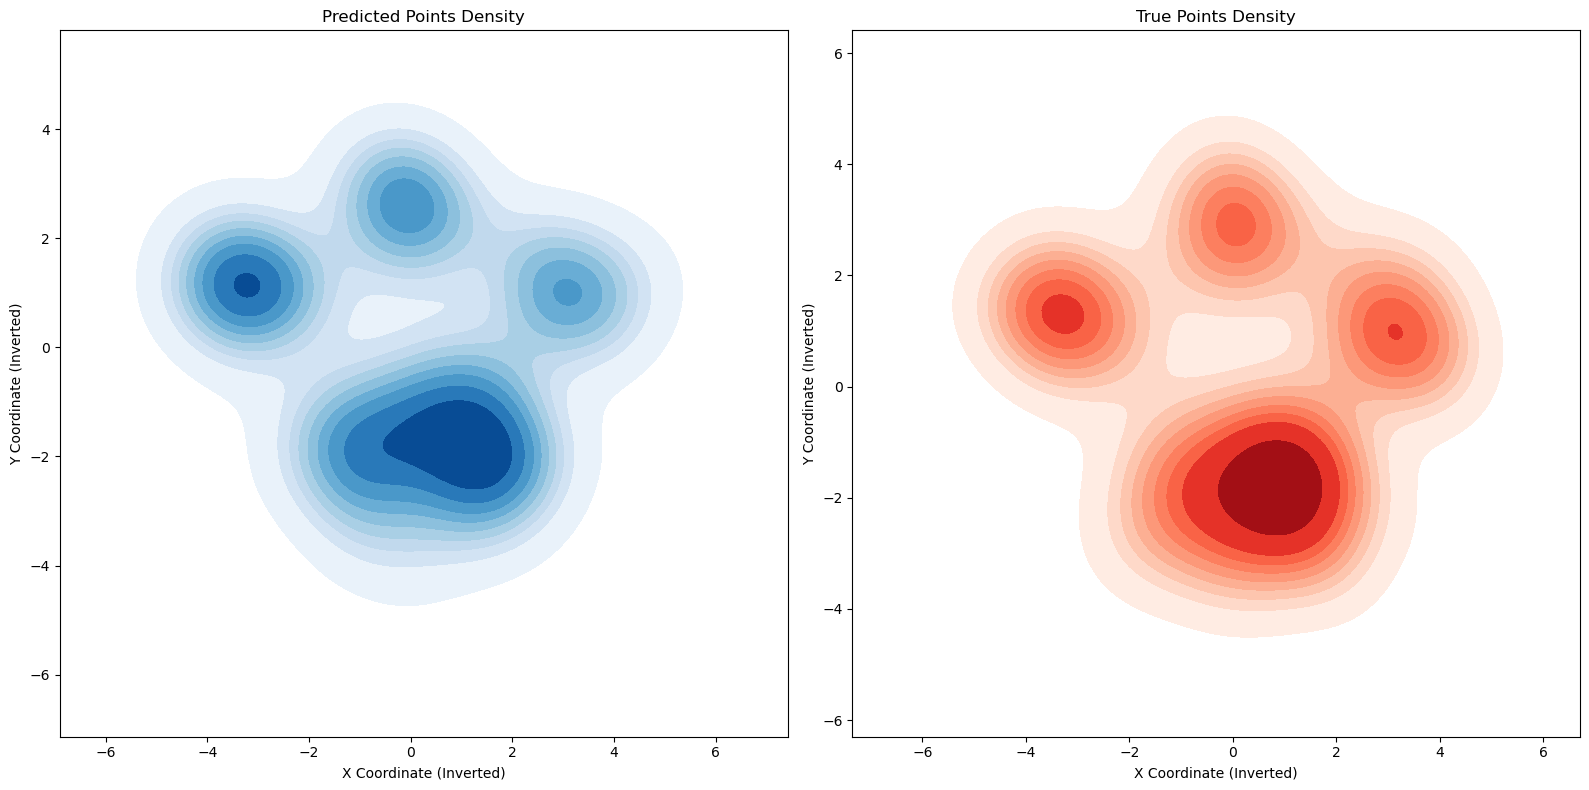

In [41]:
import seaborn as sns


# Invert the coordinates by flipping both x and y axes
def invert_coordinates(x, y):
    return x, -y

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Collect predicted points for plotting density
pred_x, pred_y = [], []
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one
    num_points = int(predicted_points[hit_loc])
    # Apply coordinate inversion
    x_samples, y_samples = invert_coordinates(
        np.random.normal(loc=mean[0], scale=std_dev, size=num_points),
        np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    )
    pred_x.extend(x_samples)
    pred_y.extend(y_samples)

# Plot kernel density estimate for predicted points
sns.kdeplot(x=pred_x, y=pred_y, fill=True, ax=axs[0], cmap='Blues')
axs[0].set_title('Predicted Points Density')
axs[0].set_xlabel('X Coordinate (Inverted)')
axs[0].set_ylabel('Y Coordinate (Inverted)')

# Collect true points for plotting density
true_x, true_y = [], []
for hit_loc, mean in hit_location_means.items():
    if hit_loc == "hit_location_0.0":
        continue #skip this one
    num_points = int(true_points[hit_loc])
    # Apply coordinate inversion
    x_samples, y_samples = invert_coordinates(
        np.random.normal(loc=mean[0], scale=std_dev, size=num_points),
        np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
    )
    true_x.extend(x_samples)
    true_y.extend(y_samples)

# Plot kernel density estimate for true points
sns.kdeplot(x=true_x, y=true_y, fill=True, ax=axs[1], cmap='Reds')
axs[1].set_title('True Points Density')
axs[1].set_xlabel('X Coordinate (Inverted)')
axs[1].set_ylabel('Y Coordinate (Inverted)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


